In [1]:
import os
import numpy as np
import librosa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from skimage.transform import resize
from keras.regularizers import l1_l2

import matplotlib.pyplot as plt

# Define your folder structure
train_dir = '/content/drive/MyDrive/Cat/Cleaned/aug/train'
val_dir = '/content/drive/MyDrive/Cat/Cleaned/aug/val'
test_dir = '/content/drive/MyDrive/Cat/Cleaned/aug/test'

def load_and_preprocess_data(data_dir, target_length=16000, size=64):
    data = []
    labels = []
    classes = sorted(os.listdir(data_dir))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            audio_data, _ = librosa.load(file_path, sr=target_length)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=target_length)
            #chroma = librosa.feature.chroma_stft(y=audio_data, sr=target_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=target_length)
            #tonnetz = librosa.feature.tonnetz(y=audio_data, sr=target_length)
            mfccs = librosa.feature.mfcc(y=audio_data, sr=target_length, n_mfcc=40)

            mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (size, size))
            #chroma = resize(np.expand_dims(chroma, axis=-1), (size, size))
            spectral_contrast = resize(np.expand_dims(spectral_contrast, axis=-1), (size, size))
            #tonnetz = resize(np.expand_dims(tonnetz, axis=-1), (size, size))
            mfccs = resize(np.expand_dims(mfccs, axis=-1), (size, size))
            features = np.concatenate([mel_spectrogram, mfccs], axis=-1)
            #features = np.concatenate([mel_spectrogram, mfccs], axis=-1)

            data.append(features)
            labels.append(i)

    return np.array(data), np.array(labels), classes

# Load and preprocess data
X_train, y_train, classes = load_and_preprocess_data(train_dir)
X_val, y_val, _ = load_and_preprocess_data(val_dir)
X_test, y_test, _ = load_and_preprocess_data(test_dir)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))




In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='elu')(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.9)(x)
output_layer = Dense(len(classes), activation='softmax', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
model = Model(input_layer, output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model with data augmentation and callbacks for early stopping, learning rate reduction, and training evaluation
batch_size = 32
epochs = 1000

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=50, min_lr=1e-12)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Cat/Cleaned/best_model4.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('/content/drive/MyDrive/Cat/Cleaned/audio_classification_simple_model4.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9751 - loss: 3.1000
Epoch 353: val_accuracy did not improve from 0.89005
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9749 - loss: 3.1010 - val_accuracy: 0.8429 - val_loss: 3.8681
Epoch 354/1000
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9882 - loss: 3.0921
Epoch 354: val_accuracy did not improve from 0.89005
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9876 - loss: 3.0926 - val_accuracy: 0.8691 - val_loss: 3.7547
Epoch 355/1000
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9837 - loss: 2.9579
Epoch 355: val_accuracy did not improve from 0.89005
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9838 - loss: 2.9525 - val_accuracy: 0.8586 - val_loss: 3.5361
Epoch 356/1000
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9809 - loss: 2.7366
Epoch 356: val_accuracy did not improve from 0.89005
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9808 - loss: 2.7346 - val_accuracy: 0.8639 - 

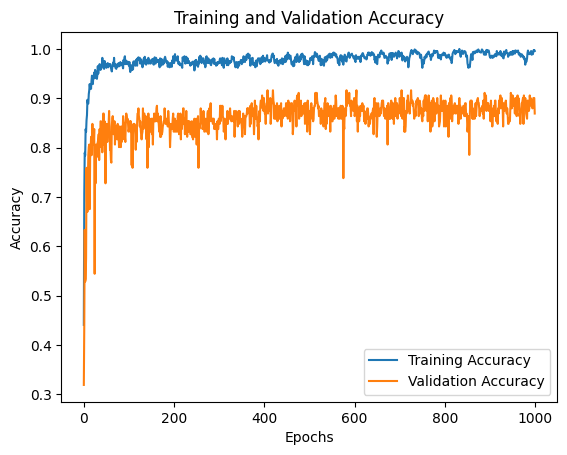

In [5]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')


Test Loss: 1.5534, Test Accuracy: 87.63%
